In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from optbinning import OptimalBinning
from sklearn.tree import DecisionTreeClassifier
from natsort import natsorted
import src.metrics as metrics
from src.binning import *
from src.optimal_binning import OptimalBinning

In [11]:
df = pd.read_csv(r"C:\Users\ruben\OneDrive\Desktop\Loan approvval\default_dataset.csv")

for col in df.columns:
    if df[col].isna().sum() > 0:
        print(f"Column {col} has {df[col].isna().sum()} missing values")
        if df[col].dtype in ['int64', 'float64']:
            df[col] = df[col].fillna(df[col].median())
        else:
            df[col] = df[col].fillna(df[col].mode()[0])

#df = df.loc[(df['person_age'] < 100) & (df['person_income'] < 250000)]
df.head()

Column person_emp_length has 895 missing values
Column loan_int_rate has 3116 missing values


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [13]:
binner = OptimalBinning(
    min_bins=2, max_bins=10, min_samples_bin=0.05, monotonic_trend='descending', p_value_threshold=0.05, variable_type="continuous"
)
binner.fit(df['person_income'], df['loan_status'])
binner.get_binning_table()

,Bin,Count,Non-event,Event,Event rate,WoE,IV,IV_percentage
0,"[-inf, 22882)",1630,597,1033,0.633742,-1.824704,0.222418,39.22
1,"[22882, 35000)",4591,2822,1769,0.385319,-0.809367,0.111766,19.71
2,"[35000, 39938)",2304,1694,610,0.264757,-0.255009,0.004926,0.87
3,"[39938, 59982)",9155,7226,1929,0.210705,0.044286,0.000544,0.10
4,"[59982, 79994)",6801,5768,1033,0.151889,0.443460,0.035968,6.34
5,"[79994, inf)",8100,7366,734,0.090617,1.029723,0.191431,33.76


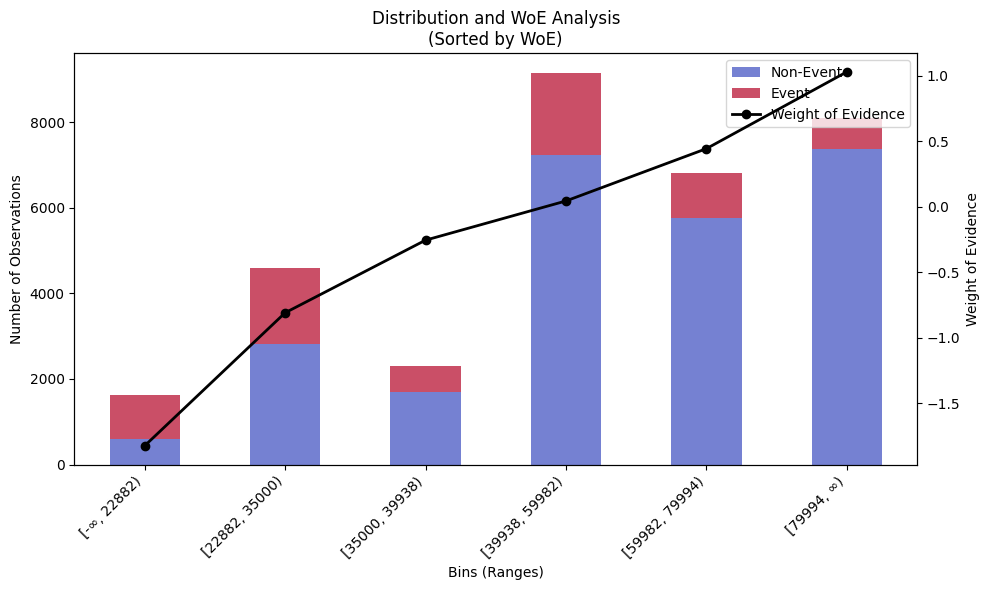

In [14]:
binner.plot_binning()

In [43]:
import optbinning as optbinning

optb = optbinning.OptimalBinning(name="person_age", dtype="numerical", solver="cp")
optb.fit(df['person_income'], df['loan_status'])
optb._binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 22882.00)",1630,0.050029,597,1033,0.633742,-1.824704,0.222418,0.024491
1,"[22882.00, 34999.50)",4591,0.140910,2822,1769,0.385319,-0.809367,0.111766,0.013601
2,"[34999.50, 39937.50)",2304,0.070716,1694,610,0.264757,-0.255009,0.004926,0.000614
3,"[39937.50, 49994.00)",4778,0.146650,3751,1027,0.214943,0.018982,0.000053,0.000007
4,"[49994.00, 59982.00)",4377,0.134342,3475,902,0.206077,0.072337,0.000689,0.000086
5,"[59982.00, 79993.50)",6801,0.208741,5768,1033,0.151889,0.44346,0.035968,0.004459
6,"[79993.50, 89325.00)",1976,0.060649,1773,203,0.102733,0.890824,0.036563,0.004425
7,"[89325.00, inf)",6124,0.187962,5593,531,0.086708,1.078111,0.156177,0.018628
8,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
9,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


In [14]:
def calculate_woe_iv(feature, target):
    woe = []
    iv = []
    for i in range(len(feature.unique())):
        val = feature.unique()[i]
        df = feature[feature == val]
        event = df[target == 1].count()
        non_event = df[target == 0].count()
        total_event = (target == 1).sum()
        total_non_event = (target == 0).sum()
        woe.append(np.log(((non_event + 1) / total_non_event) / ((event + 1) / total_event)))
        iv.append(((non_event + 1) / total_non_event - (event + 1) / total_event) * woe[i])
    return woe, iv

woe, iv = calculate_woe_iv(df['loan_intent'], df['loan_status'])
df['loan_intent_woe'] = df['loan_intent'].map(dict(zip(df['loan_intent'].unique(), woe)))

In [16]:
sum(iv)

0.0956947464620325

In [15]:
df[['loan_intent', 'loan_intent_woe']].drop_duplicates().sort_values('loan_intent_woe').reset_index(drop=True)

,loan_intent,loan_intent_woe
0,DEBTCONSOLIDATION,-0.361315
1,MEDICAL,-0.266929
2,HOMEIMPROVEMENT,-0.236444
3,PERSONAL,0.116245
4,EDUCATION,0.293229
5,VENTURE,0.472186
